# The Echo Chamber Effect - A Case Study (provisional title)

## Milestone 2

In this notebook we will download a small sample of the Reddit dataset for the first time and perform some basic statistics on it. We will talk about the structure of the data, our pipepline to handle it and how this new knowledge has affected our plans for the project.

We will also load the two recommended NLP libraries and try them out to see how they work and to which extent we can take advantage of them.

The full report can be found on the updated README.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
%matplotlib inline

import findspark
#findspark.init(r'C:\Spark\spark-2.3.2-bin-hadoop2.7')
findspark.init('/Users/vikalpkamdar/opt/spark')
#findspark.init()
findspark.find()

from datetime import datetime
from matplotlib import pyplot as plt
from pyspark.sql import *
from pyspark.sql.functions import *

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.session.timeZone', 'UTC')
sc = spark.sparkContext
sqlc = SQLContext(sc)

In [2]:
DATA_DIR = './data/'

## Sampling the data

This dataset is big beyond comprehension. Around 2TB of comments from Reddit's inception in 2005 until March 2017. Our machines cannot handle such numbers and even if they could it would take too much time. Instead, we decided to, for now, focus only on 2016 (the year of the US presidential election) which itslef represents already more than 360GB of data and sticked to the following pipeline:

 - Sample 10% of the data (~12GB compressed)
 - Try our scripts locally using spark
 - Once prototyped, upload the scripts to the cluster, run them on the whole year of data and retrieve only the essential parts

This way we streamlined the queries to the cluster and created an easily expandable workframe.

In order to filter and reduce even more the size of the datasets we dropped the columns that mostly have no use for us, namely: ```author_flair_class```, ```author_flair_text```, ```distinguished```, ```edited```, ```retrieved_on```, ```stickied``` and ```subreddit_id```. (Script used on cluster: `script/drop_col.py`)

We don't think a dataset as rich as this needs much enrichment, but we could consider using web scrapping techniques to retrieve subredit data (e.g. the rules of the subreddit).

### Using the sample to explain the data

The following code does not really need the data in its size as it's for explanatory purposes. The queries and operations were performed on our local system with 1% 2016 reddit comments. Once we figured out the querries we applied them to 10% of the 2016 reddit data (~12GB compressed) by sending python scripts (found in scripts/ folder) to the cluster.

In [50]:
df_spark = spark.read.parquet(DATA_DIR + "sample2016_1.parquet")

In [51]:
# Sample size
df_spark.count() # number of comments used for the 1% dataset.

7999762

Firstly we show the column names of the spark data frame and the first row in order to analyze how the data frame is structured, the differents columns and its meanings:

In [52]:
df_spark.columns

['author',
 'author_flair_css_class',
 'author_flair_text',
 'body',
 'controversiality',
 'created_utc',
 'distinguished',
 'edited',
 'gilded',
 'id',
 'link_id',
 'parent_id',
 'retrieved_on',
 'score',
 'stickied',
 'subreddit',
 'subreddit_id',
 'ups']

In [53]:
# example of 1 comment
df_spark.show(1)

+-----------+----------------------+-----------------+--------------------+----------------+-----------+-------------+------+------+-------+---------+---------+------------+-----+--------+---------+------------+----+
|     author|author_flair_css_class|author_flair_text|                body|controversiality|created_utc|distinguished|edited|gilded|     id|  link_id|parent_id|retrieved_on|score|stickied|subreddit|subreddit_id| ups|
+-----------+----------------------+-----------------+--------------------+----------------+-----------+-------------+------+------+-------+---------+---------+------------+-----+--------+---------+------------+----+
|Tsobaphomet|               warrior|                 |Thanks :)

I was ...|               0| 1478922864|         null| false|     0|d9wsqvf|t3_5ce8ec|t3_5ce8ec|  1481414536|    1|   false|      wow|    t5_2qio8|null|
+-----------+----------------------+-----------------+--------------------+----------------+-----------+-------------+------+------+

Here we explain the columns one by one:
* __'author':__ Redditor username
* __'author_flair_css_class':__ CSS class, defines the style of the 'author_flair_text' tag within the html of Reddit.
* __'author_flair_text':__  A tag associated to your username, which is only visible in the current subreddit. 
* __'body':__ The content of the comment.
* __'controversiality':__ When its value is 1, the comment has been voted above a certain threshold and has roughly the same amount of downvotes and upvotes. 0 Otherwise. [More info](https://www.reddit.com/r/redditdev/comments/29i58s/reddit_change_api_availability_controversiality/)
* __'created_utc':__ Unix timestamp of the creation date.
* __'distinguished':__ If a comment is distinguished, this means that a moderator or admin of the subreddit has highlighted it (A little [M] will appear next to it).
* __'edited':__ Indicates if the comment has been edited. If it has not been edited the variable is False, else its value is the Unix Timestamp of the last edition.
* __'gilded':__ When its value is 1, that means a [premium](https://www.reddit.com/premium/) user gave the author [reddit gold](https://www.reddit.com/coins/) (a week of reddit premium). 
* __'id':__ Unique ID of the comment.
* __'link_id':__ Id of the link (similar to post) this comment is anwering to. Always begins with 't3_'.
* __'parent_id':__ Id of the post this comment is below. Always begins with 't3_'.
* __'retrieved_on':__ Unix Timestamp of the comment retrieval (to this data set).
* __'score':__ Upvotes minus downvotes (Reddit mildly obfuscates this value when the comment has lots of votes as a security measure against external meddling. This is called [vote fuzzing](https://www.reddit.com/r/firstdayontheinternet/comments/30b44n/could_someone_explain_how_the_reddit_karma_system/).
* __'stickied':__ Boolean value. When a comment is stickied (by a moderator or admin), the comment appears as the first entry right below the original post.
* __'subreddit':__ Name of the subreddit where the comment was posted.
* __'subreddit_id':__ Unique ID (or full name as refered to in the Rddit API) of the subreddit. Note that those always begin with 't5_'.

The types of each column:

In [54]:
df_spark.distinct()

DataFrame[author: string, author_flair_css_class: string, author_flair_text: string, body: string, controversiality: bigint, created_utc: bigint, distinguished: string, edited: string, gilded: bigint, id: string, link_id: string, parent_id: string, retrieved_on: bigint, score: bigint, stickied: boolean, subreddit: string, subreddit_id: string, ups: bigint]

And the different values of some of the columns (only the relevant ones):

In [55]:
df_spark[['controversiality']].distinct().show(4)

+----------------+
|controversiality|
+----------------+
|               0|
|               1|
+----------------+



In [56]:
df_spark[['distinguished']].distinct().show(4)

+-------------+
|distinguished|
+-------------+
|         null|
|    moderator|
|        admin|
+-------------+



In [57]:
df_spark[['edited']].distinct().show(2)

+----------+
|    edited|
+----------+
|1478967096|
|1478978657|
+----------+
only showing top 2 rows



In [58]:
df_spark[['link_id']].distinct().orderBy(desc("link_id")).show(3)

+--------+
| link_id|
+--------+
|t3_y5ggc|
|t3_wadsy|
|t3_st22f|
+--------+
only showing top 3 rows



In [59]:
df_spark[['score']].orderBy(asc('score')).show(3)

+-----+
|score|
+-----+
|-1032|
| -722|
| -655|
+-----+
only showing top 3 rows



Number of subreddits in our 1% sample:

In [60]:
df_spark[['subreddit_id']].distinct().count()

50076

Number of controversial comments in our 1% sample:

In [61]:
df_spark.filter('controversiality = 1').count()

177039

For most of the local processing we will use pandas as it is easier. By the time our data pieces will be filtered and small enough to not run into memory constraints. Using pyarrow we can read parquet files directly into pandas dataframes.

conda install pyarrow, we get an error if we try to transform the spark dataframe

In [62]:
df_pd = pd.read_parquet(DATA_DIR + "sample2016_1.parquet")

We will now print out some basic properties and stats about our 1% data sample.

In [63]:
df_pd.head(2)

,author,author_flair_css_class,author_flair_text,body,controversiality,created_utc,distinguished,edited,gilded,id,link_id,parent_id,retrieved_on,score,stickied,subreddit,subreddit_id,ups
0,AnxiousPatient,None,None,It's possible I may have been that day.,0,1465330644,None,false,0,d3zwugc,t3_4mzr8r,t1_d3zwjop,1468878282,1,False,AskReddit,t5_2qh1i,1.0
1,dirtymoney,None,None,r/shoplifting would love that,0,1465330650,None,false,0,d3zwum0,t3_4n0ghs,t1_d3zu5ud,1468878284,1,False,WTF,t5_2qh61,1.0


In [64]:
df_pd[['controversiality', 'distinguished', 'edited', 'parent_id']].values

array([[0, None, 'false', 't1_d3zwjop'],
       [0, None, 'false', 't1_d3zu5ud'],
       [0, None, 'false', 't3_4n1136'],
       ...,
       [0, None, 'false', 't1_czj41je'],
       [0, None, 'false', 't1_czj40e1'],
       [0, None, 'false', 't1_czj41ru']], dtype=object)

In [65]:
df_pd.shape

(7999762, 18)

In [66]:
len(df_pd['id'].unique())

7999762

From the two cells above we can confirm that the `id` is unique.

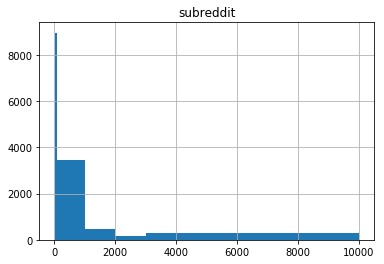

In [67]:
df_pd['subreddit'].value_counts().to_frame().hist(bins=[10,100,1000,2000,3000,10000]);

As we can see from the histogram above, a lot of the subreddits have only 1 comment. Hence these subreddits will be considered as outliers, as we feel they do will not help us in our eco-chamber calculations.

We need to decide a threshold for the number of comments per subreddit. Subreddits below that threshold will not bring us much if not any information in our calculations for milestone 3.

Let us now see a general pictures for the number of 

([], <a list of 0 Text yticklabel objects>)

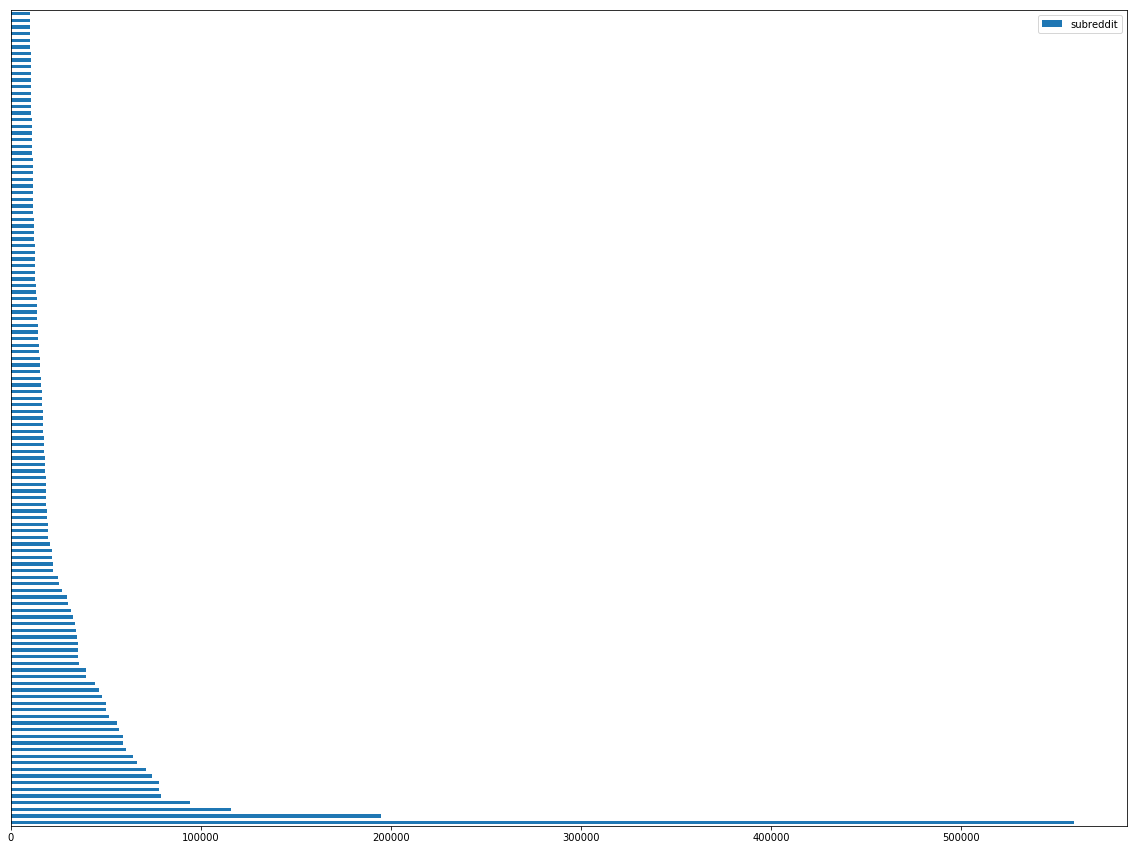

In [104]:
df_pd['subreddit'].value_counts().to_frame()[df_pd['subreddit'].value_counts() > 10000].plot(kind='barh', figsize=(20,15));
plt.yticks([])

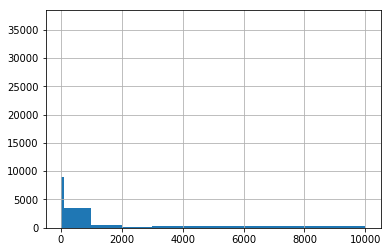

In [70]:
df_pd['subreddit'].value_counts().hist(bins=[0,10,100,1000,2000,3000,10000]);

In [71]:
df_pd[df_pd['subreddit'] == 'AskReddit'].head(3)

,author,author_flair_css_class,author_flair_text,body,controversiality,created_utc,distinguished,edited,gilded,id,link_id,parent_id,retrieved_on,score,stickied,subreddit,subreddit_id,ups
0,AnxiousPatient,None,None,It's possible I may have been that day.,0,1465330644,None,false,0,d3zwugc,t3_4mzr8r,t1_d3zwjop,1468878282,1,False,AskReddit,t5_2qh1i,1.0
20,RCBurnout11,None,None,"They apologize excessively, they're always the...",0,1465330706,None,false,0,d3zww5m,t3_4n10jv,t3_4n10jv,1468878304,3909,False,AskReddit,t5_2qh1i,3909.0
26,cyberbeast41,None,None,"Dr. Ian Malcolm:""Oh, yeah. Oooh, ahhh, that's ...",0,1465330742,None,false,0,d3zwx5q,t3_4n0rh4,t3_4n0rh4,1468878318,3,False,AskReddit,t5_2qh1i,3.0


In [72]:
df_pd.dtypes

author                     object
author_flair_css_class     object
author_flair_text          object
body                       object
controversiality            int64
created_utc                 int64
distinguished              object
edited                     object
gilded                      int64
id                         object
link_id                    object
parent_id                  object
retrieved_on                int64
score                       int64
stickied                     bool
subreddit                  object
subreddit_id               object
ups                       float64
dtype: object

### Statistics on the cluster

In this part we show what we can do some of the above operations on a bigger dataset (10% of the 2016 reddit comments). Firstly we will show the functions we will use to obtain simple statistics. In the next part we will export these commands onto a python script (script/stats.py) and run them on the 10% sampled 2016 reddit comments.

The stats below are done on the 1% sample of the 2016 reddit comments. But they were just done in order to find the right functions.

In [73]:
total_n_comments = df_spark.count()
total_n_comments

7999762

First we compute the number of removed comments (A comment has been removed when its body is "[deleted]")

In [74]:
n_deleted_comments = df_spark.filter('body = "[deleted]"').count()
n_deleted_comments 

341616

The percentage of comments that are "removed" according to the above criteria.

In [75]:
percentage_deleted_comments = 100 * n_deleted_comments  / total_n_comments
percentage_deleted_comments

4.270327042229506

And the number of comments posted by removed users (Users who have removed their account after post the comment)

In [76]:
comments_by_removed_users = df_spark.filter('author = "[deleted]"').count()
comments_by_removed_users

570574

The percentage of comments that were posted by "removed" users according to the above criteria.

In [77]:
percentage_by_dl_user = 100 * comments_by_removed_users / total_n_comments
percentage_by_dl_user

7.132387188518859

Now we see the total number of controversial comments and the percentage of them:

In [78]:
n_controversial_comments = df_spark.filter('controversiality = 1').count()
n_controversial_comments

177039

In [79]:
perc_controversial_comments = 100 * n_controversial_comments / total_n_comments
perc_controversial_comments

2.2130533383368154

Having easily computed this percentages, we now get a dataframe with the number of comments per subrredit in order to plot the distribution:

In [80]:
#Total number of subreddits:
df_spark[['subreddit']].distinct().count()

50076

In [81]:
df_subreddit_count = df_spark.groupBy('subreddit').agg(count('*')).withColumnRenamed('count(1)', 'Number of comments')
df_subreddit_count

DataFrame[subreddit: string, Number of comments: bigint]

In [82]:
df_subreddit_count.show(2)

+----------+------------------+
| subreddit|Number of comments|
+----------+------------------+
|     anime|             27013|
|MensRights|              4027|
+----------+------------------+
only showing top 2 rows



We have not analyzed the statistics above as they are merely there for us to find the right functions to use wth the cluster.

We will now show the stats with a bigger dataset (10% of the 2016 reddit comments).

The pipeline we used is the following:
1. We first read all of the data in the 2016 .bz2 compressed files and sampled 10% of it to run our querries with the cluster (`script/read_data_original.py`)
2. We then sampled another 10% to obtain 1% of the 2016 reddit comments that we played with above (`scripts/read_data.py`)
3. Once we found the correct form for our querries on the smaller dataset, we ran them with cluster on the larger dataset (`scripts/`) and saved them to smaller sized parquet files.
4. We then imported these smaller parquet files into our local machine and read them and transformed them to pandas dataframes in order to plot the graphs.

The above stats were obtained using `scripts/stats.py` with cluster. The stats were saved in a text file (`data/stats.txt`). 

Total number of comments: 79998223  
Number of deleted comments: 3414381  
% of deleted comments: 4  
Number of comments by removed users: 5706216  
% comments by deleted users: 7  
Number of controversial comments: 1770571  
% of controversial comments: 2  
Number of subreddits: 131028  

We first decided to have a look at the number of querries per subreddit (`scripts/stats.py`)

In [84]:
df_subreddit_count = spark.read.parquet(DATA_DIR + 'df_subreddit_count.parquet')

In [85]:
df_subreddit_count.show(3)

+-----------------+------------------+
|        subreddit|Number_of_comments|
+-----------------+------------------+
|HollowRealization|               216|
|         buildapc|            183435|
|NoStupidQuestions|             60895|
+-----------------+------------------+
only showing top 3 rows



In [86]:
df_subreddit_count.toPandas().shape

(131028, 2)

Let us now plot the 10 most 'popular' (commented) subbreddits. As they are the ones to give us the most information in our future calculations.

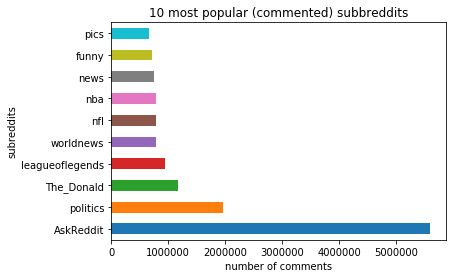

In [110]:
df_tmp = df_subreddit_count.toPandas().sort_values(by = "Number_of_comments", ascending = False).iloc[:10,:]
df_tmp.plot(kind='barh',x = "subreddit", y = "Number_of_comments",legend = None)
plt.title('10 most popular (commented) subbreddits')
plt.xlabel('number of comments');
plt.ylabel('subreddits');

And now 10 least popular subreddits, as they will potentially be removed.

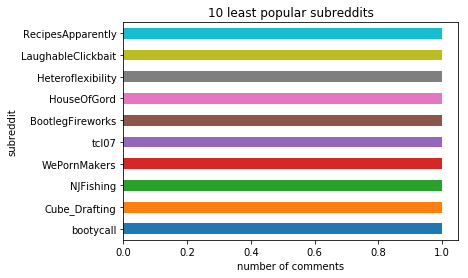

In [115]:
df_tmp = df_subreddit_count.toPandas().sort_values(by = "Number_of_comments", ascending = True).iloc[:10,:]
df_tmp.plot(kind='barh',x = "subreddit", y = "Number_of_comments", legend = None);
plt.title('10 least popular subreddits')
plt.xlabel('number of comments');

As we can see the last 10 all have exactly 1 comment.

Let us now try to see how many subreddits have 1 comment.

In [89]:
df_subreddit_count_pd = df_subreddit_count.toPandas()

In [90]:
n_subreddits_per_comment = df_subreddit_count_pd.groupby('Number_of_comments').count()

In [92]:
n_subreddits_per_comment.head()

,subreddit
Number_of_comments,
1,52023
2,19478
3,8884
4,5233
5,3648


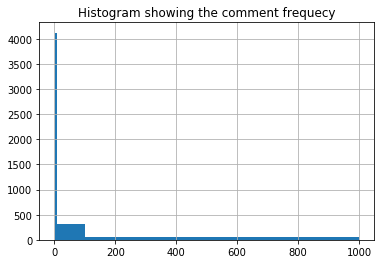

In [121]:
n_subreddits_per_comment.hist(bins = [1,10,100,1000]);
plt.title('Histogram showing the comment frequecy');

As we can see a lot of the subreddits have 1 comment, hence removing these will reduce the size of our dataset.

Let us now analyze the controversiality of the comments (`script/stats.py`)

In [116]:
df_controversial_per_subr_count = spark.read.parquet(DATA_DIR + "df_controversial_per_subr_count.parquet")
df_controversial_per_subr_count.show(2)

+---------+------------------------+
|subreddit|N_controversial_comments|
+---------+------------------------+
|  Roadcam|                    1820|
|      MLS|                    2249|
+---------+------------------------+
only showing top 2 rows



In [95]:
df_controversial_per_subr_count_pd = df_controversial_per_subr_count.toPandas()

10 most controversial subreddits

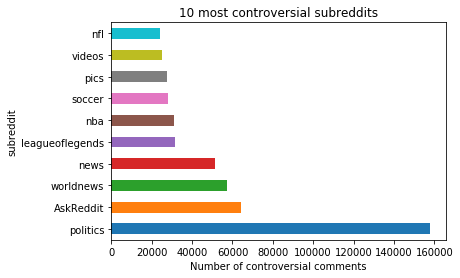

In [117]:
df_controversial_per_subr_count_pd.sort_values(by='N_controversial_comments',ascending=False).iloc[:10,:].plot(kind='barh',x='subreddit',y='N_controversial_comments',legend=None);
plt.title('10 most controversial subreddits');
plt.xlabel('Number of controversial comments');

10 least controversial subreddits

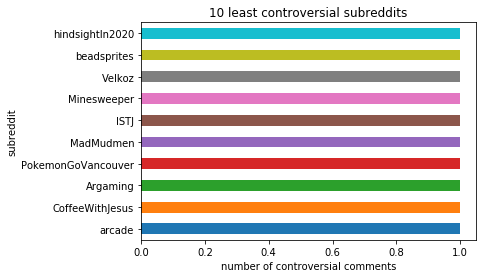

In [123]:
df_controversial_per_subr_count_pd.sort_values(by='N_controversial_comments',ascending=True).iloc[:10,:].plot(kind='barh',x='subreddit',y='N_controversial_comments',legend = None)
plt.title('10 least controversial subreddits');
plt.xlabel('number of controversial comments');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1828c860>]],
      dtype=object)

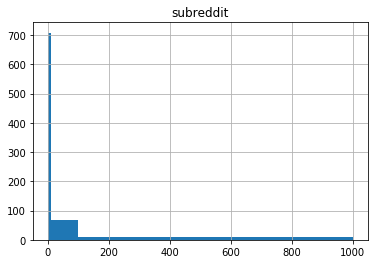

In [98]:
df_controversial_per_subr_count_pd.groupby('N_controversial_comments').count().hist(bins=[1,10,100,1000])

As we can see in the graph for most popular subbreddits (comments and controversial comments)

With this two data frames we can check if there exists a correlation between the percentage of controversial comments and the total number of comments; i.e if there exists a correlation between the subreddit controversiality (measured by the percentage of comments that are controversial) with the subreddit popularity (measured by the number of comments in the subreddit). 

(Note that we do the join between both data frames and then compute the percentage of controversial comments)

In [17]:
df_crr = df_controversial_per_subr_count.join(df_subreddit_count, "subreddit") 
df_crr = df_crr.select('subreddit', 'Number_of_comments', 100* df_crr['N_controversial_comments'] / df_crr['Number_of_comments'])
df_crr = df_crr.withColumnRenamed("Number_of_comments", "Popularity").withColumnRenamed("((N_controversial_comments * 100) / Number_of_comments)", "Controversiality")
df_crr.show(2)

+-----------------+----------+-------------------+
|        subreddit|Popularity|   Controversiality|
+-----------------+----------+-------------------+
|         buildapc|    183435|0.38215171586665575|
|NoStupidQuestions|     60895|  1.668445685195829|
+-----------------+----------+-------------------+
only showing top 2 rows



In [18]:
df_crr.corr("Popularity", "Controversiality")

0.012989449165195099

In [20]:
df_corr_contr_comm = df_controversial_per_subr_count.join(df_subreddit_count, "subreddit")

In [21]:
df_corr_contr_comm.show(3)

+-----------------+------------------------+------------------+
|        subreddit|N_controversial_comments|Number_of_comments|
+-----------------+------------------------+------------------+
|         buildapc|                     701|            183435|
|NoStupidQuestions|                    1016|             60895|
|            scuba|                      39|              5219|
+-----------------+------------------------+------------------+
only showing top 3 rows



In [22]:
df_corr_contr_comm.corr("N_controversial_comments","Number_of_comments")

0.7217845223907968

Stronger correlation.

We see there is no correlation between popularity and controversiality, what could be a good factor for our analysis of the echo-chambing effect; since this mean that when a subreddit is so big, it does not implie that there would be more discussions (controversial discussions) in percentage.

At that point we look at the timeline of activity (it could be useful for relating spikes to real-life events). What we are going to do is to fix the first timestamp of our data set as the initial moment, as 0 (and the rest of the timestamp according to this fact). Finally we plot the timeline:

Note: Locally, we have loaded a sample from the dataset of January 2017

In [45]:
df_spark[['created_utc']].orderBy(asc('created_utc')).show(1)

+-----------+
|created_utc|
+-----------+
| 1483228800|
+-----------+
only showing top 1 row



In [46]:
df_spark[['created_utc']]

DataFrame[created_utc: bigint]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FB6FD315C0>]],
      dtype=object)

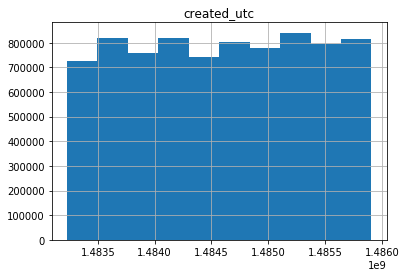

In [47]:
df_spark[['created_utc']].toPandas().hist()

In [48]:
df_spark.orderBy("id").show(2)

+----------+----------------------+-----------------+--------------------+----------------+-----------+-------------+------+------+-------+---------+----------+------------+-----+--------+------------+------------+
|    author|author_flair_css_class|author_flair_text|                body|controversiality|created_utc|distinguished|edited|gilded|     id|  link_id| parent_id|retrieved_on|score|stickied|   subreddit|subreddit_id|
+----------+----------------------+-----------------+--------------------+----------------+-----------+-------------+------+------+-------+---------+----------+------------+-----+--------+------------+------------+
|    Godcon|                  null|             null|Do you buy the mi...|               0| 1483228800|         null| false|     0|dbumnq3|t3_5l9ny9|t1_dbukpfs|  1485679711|    2|   false|minipainting|    t5_2scss|
|Fleetthrow|                  null|             null|Can I ask where y...|               0| 1483228800|         null| false|     0|dbumnq6|t

In [34]:
df_created_utc = spark.read.parquet(DATA_DIR + "df_comments_per_month.parquet")

In [35]:
df_created_utc_pd = df_created_utc.toPandas()

In [36]:
df_created_utc_pd = df_created_utc_pd.iloc[:12,:].merge(df_created_utc_pd.iloc[12:,:], right_on = 'count', left_on = 'count')
df_created_utc_pd = df_created_utc_pd[['month_y','month_x','count']]
df_created_utc_pd.columns = ['month_int','month_string','n_of_comments']
df_created_utc_pd = df_created_utc_pd.sort_values(by='month_int',ascending=True)

In [37]:
df_created_utc_pd

,month_int,month_string,n_of_comments
10,01,Jan,6197158
8,02,Feb,5920985
7,03,Mar,6392263
4,04,Apr,6425634
0,05,May,6521400
6,06,Jun,6587116
3,07,Jul,6695343
9,08,Aug,6971881
2,09,Sep,6701333
5,10,Oct,7183135


In [44]:
df_created_utc_controversial = spark.read.parquet(DATA_DIR + "df_created_utc_controversial.parquet")

In [45]:
df_created_utc_controversial_pd = df_created_utc_controversial.toPandas()
df_created_utc_controversial_pd.sort_values(by="month",ascending=True)
df_created_utc_controversial_pd.columns = ['month_int','n_of_controversial']

In [46]:
df_created_utc_non_controversial = spark.read.parquet(DATA_DIR + "df_created_utc_non_controversial.parquet")

In [47]:
df_created_utc_non_controversial_pd = df_created_utc_non_controversial.toPandas()
df_created_utc_non_controversial_pd = df_created_utc_non_controversial_pd.sort_values(by='month',ascending=True)
df_created_utc_non_controversial_pd.columns = ['month_int','n_of_non_controversial']

In [48]:
df_created_utc_pd = df_created_utc_pd.merge(df_created_utc_controversial_pd,left_on='month_int',right_on = 'month_int')
df_created_utc_pd = df_created_utc_pd.merge(df_created_utc_non_controversial_pd,left_on='month_int',right_on = 'month_int')

In [49]:
df_created_utc_pd

,month_int,month_string,n_of_comments,n_of_controversial,n_of_non_controversial
0,01,Jan,6197158,150127,6047031
1,02,Feb,5920985,141455,5779530
2,03,Mar,6392263,151851,6240412
3,04,Apr,6425634,147945,6277689
4,05,May,6521400,157029,6364371
5,06,Jun,6587116,147958,6439158
6,07,Jul,6695343,152563,6542780
7,08,Aug,6971881,154129,6817752
8,09,Sep,6701333,148136,6553197
9,10,Oct,7183135,152879,7030256


### Natural Language Processing

As a final step wiithin milestone 2, below are our first steps with NLP, basically trying out the sugested libraries. Here's a reference with some more libraries https://elitedatascience.com/python-nlp-libraries

To use this libraries in a simple way and in order to execute queries quickly we are going to study now just the comments of one of the subreddits of the sample, "The_Donald".

In [30]:
df_nlp = df_pd[df_pd["subreddit"] == "The_Donald"].sample(10000)

NameError: name 'df_pd' is not defined

In [81]:
df_nlp.shape

(10000, 17)

### spaCy

spaCy allows us to find named entities, thus identying the topic(s) of a post or discussion. spaCy can be found here https://spacy.io/ with instructions for installing here https://spacy.io/usage/

In [88]:
# For the installation: Execute in the anaconda prompt:
# pip install spacy
# python -m spacy download en_core_web_sm #(With admin permissions)
import spacy

spaCy features an extremely fast statistical entity recognition system, that assigns labels to contiguous spans of tokens. The default model identifies a variety of named and numeric entities, including companies, locations, organizations and products. You can add arbitrary classes to the entity recognition system, and update the model with new examples.

From this library we are going to use the "Named Entity Recognition" functionality:

A named entity is a "real-world object" that's assigned a name – for example, a person, a country, a product or a book title. spaCy can recognise various types of named entities in a document, by asking the model for a prediction. Because models are statistical and strongly depend on the examples they were trained on, this doesn't always work perfectly and might need some tuning later, depending on your use case.

Named entities are available as the ents property of a Doc:

In [83]:
doc = nlp(u'Apple is looking at buying U.K. startup for $1 billion')
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Apple 0 5 ORG
U.K. 27 31 GPE
$1 billion 44 54 MONEY


Having done this simple query, let's see which are the usuals named entities of the "The_Donald" subreddit comments. 

Note: We have done this grammatical analysis using the function npl.pipe, in order to make faster the execution.

In [84]:
tags = []
for doc in nlp.pipe(df_nlp["body"].astype('unicode').values, batch_size=50,
                        n_threads=4):
    if doc.is_parsed:
        tags.append([ent.label_ for ent in doc.ents])


In [85]:
tags = [val for sublist in tags for val in sublist]  #From a list of lists to a list

In [86]:
df_npl_pd = pd.DataFrame(tags, columns=["tags"])
tags_count = df_npl_pd.tags.value_counts().sort_values(ascending=False)
tags_count.head(5)

ORG       5787
PERSON    3013
GPE       2126
NORP      1338
DATE      1231
Name: tags, dtype: int64

So we see that the most popular tags in this subreddit are  ORG, PERSON, GPE, NORP and DATE. Below you can see the meaning of each tag:
* PERSON	People, including fictional.
* NORP	Nationalities or religious or political groups.
* FAC	Buildings, airports, highways, bridges, etc.
* ORG	Companies, agencies, institutions, etc.
* GPE	Countries, cities, states.
* LOC	Non-GPE locations, mountain ranges, bodies of water.
* PRODUCT	Objects, vehicles, foods, etc. (Not services.)
* EVENT	Named hurricanes, battles, wars, sports events, etc.
* WORK_OF_ART	Titles of books, songs, etc.
* LAW	Named documents made into laws.
* LANGUAGE	Any named language.
* DATE	Absolute or relative dates or periods.
* TIME	Times smaller than a day.
* PERCENT	Percentage, including "%".
* MONEY	Monetary values, including unit.
* QUANTITY	Measurements, as of weight or distance.
* ORDINAL	"first", "second", etc.
* CARDINAL	Numerals that do not fall under another type.

Finally we plot the appearances of each tag in the sample studied:

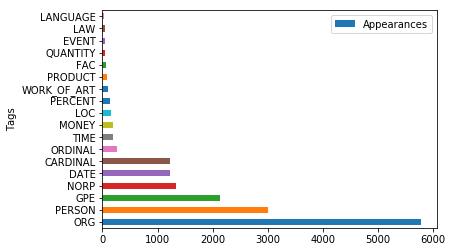

In [87]:
df_tags_count = pd.DataFrame(tags_count).reset_index()
df_tags_count.columns=["Tags", "Appearances"]
df_tags_count.set_index("Tags")

df_tags_count.plot(kind="barh", x = "Tags", y = "Appearances")

### TextBlob

TextBlob allows for sentiment analysis, translation, and more

TextBlob can be found here https://textblob.readthedocs.io/en/dev/ with installation instructions here https://textblob.readthedocs.io/en/dev/install.html

In [75]:
from textblob import TextBlob

We try the sentiment analysis this library offers:

The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.
```
 testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
 testimonial.sentiment
 Output: Sentiment(polarity=0.39166666666666666, subjectivity=0.4357142857142857)
 testimonial.sentiment.polarity
0.39166666666666666

```

Now let's try to see how is the sentiment analysis of the "The_Donald" subreddit comments. We have added two columns to the original data frame, one with the polarity measured and the other with the other with the subjectivity.

In [89]:
df_nlp['sentiment_polarity'] = df_nlp["body"].apply(lambda com: TextBlob(str(com)).sentiment.polarity)
df_nlp['sentiment_subjectivity'] = df_nlp["body"].apply(lambda com: TextBlob(str(com)).sentiment.subjectivity)

In [90]:
df_nlp.head(2)

,author,author_flair_css_class,author_flair_text,body,controversiality,created_utc,distinguished,edited,gilded,id,link_id,parent_id,retrieved_on,score,stickied,subreddit,subreddit_id,sentiment_polarity,sentiment_subjectivity
4727169,Intergalactic_Walrus,None,None,"""Just in case you didn't read it"" ahahahaha",0,1485829331,None,false,0,dd4k9xc,t3_5r4ix1,t1_dd4k8tj,1486575256,5,False,The_Donald,t5_38unr,0.0,0.0
1577915,AnyoneButBernie,None,None,I lose a lot of respect for someone if they sa...,0,1484102630,None,false,0,dc9q9rd,t3_5n7is3,t1_dc9odj6,1485949069,3,False,The_Donald,t5_38unr,0.0,0.0


Finally, we plot the distribution of both polarity and subjectivity.   

Reminder: The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

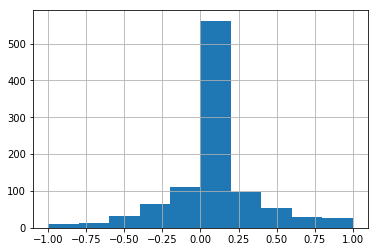

In [78]:
df_nlp['sentiment_polarity'].hist()

With the polarity distribution we check that most of the comments usually are no so polarized. However there is a considerable amount of comments polarized. 

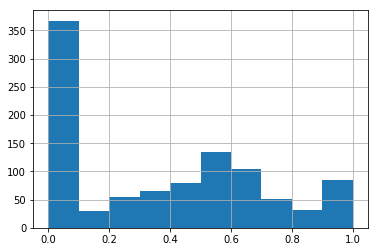

In [79]:
df_nlp['sentiment_subjectivity'].hist()

With the subjectivity distribution we also see that there are lots of comments which are somehow subjectives, although the most common is not being subjective.